In [92]:
using HDF5
#using Plots
#using jlgr
using GRUtils
using Statistics
#using jlgr
#using Colors
#Plots.GRBackend()

In [93]:
filename = "BrioWu_0009.hdf5"
#filename = "BrioWu_START.hdf5"
#filename = "BrioWu_START_HUGEVISK.hdf5"
#filename = "BrioWu_START_sDIVnVSI.hdf5"
#filename = "BrioWu.hdf5"
pos = h5read(filename,"PartType0/Coordinates")
Bfl = h5read(filename,"PartType0/Bfield") 
Vel = h5read(filename,"PartType0/Velocities")
alp = h5read(filename,"PartType0/EPalpha")
bet = h5read(filename,"PartType0/EPbeta")
Ids = h5read(filename,"PartType0/ParticleIDs")
h   = h5read(filename,"PartType0/SmoothingLengths")
rho = h5read(filename,"PartType0/Densities")
divB = h5read(filename,"PartType0/divB")
head = h5readattr(filename,"Header")
print("Leyendo ",filename," at time: ",head["Time"],"\n")
x = pos[1,:]
y = pos[2,:]
z = pos[3,:]
Bx = Bfl[1,:]
By = Bfl[2,:]
Bz = Bfl[3,:]
Vx = Vel[1,:]
Vy = Vel[2,:]
Vz = Vel[3,:]

#idx= (x .< 1.0) 
#x[idx] = x[idx] .+ abs.(x[idx].-1.0)
#idx= (x .> 3.0) 
#x[idx] = x[idx] .- abs.(x[idx].-3.0)

v2 = Vx.*Vx.+Vy.*Vy.+Vz.*Vz
b2 = By.*By.+By.*By.+Bz.*Bz
b2 = bet
print(minimum(b2)," ",maximum(b2),"\n")
Npart=size(Ids,1)

Leyendo BrioWu_0009.hdf5 at time: [0.18]
-2.74847 -0.0017586137


589824

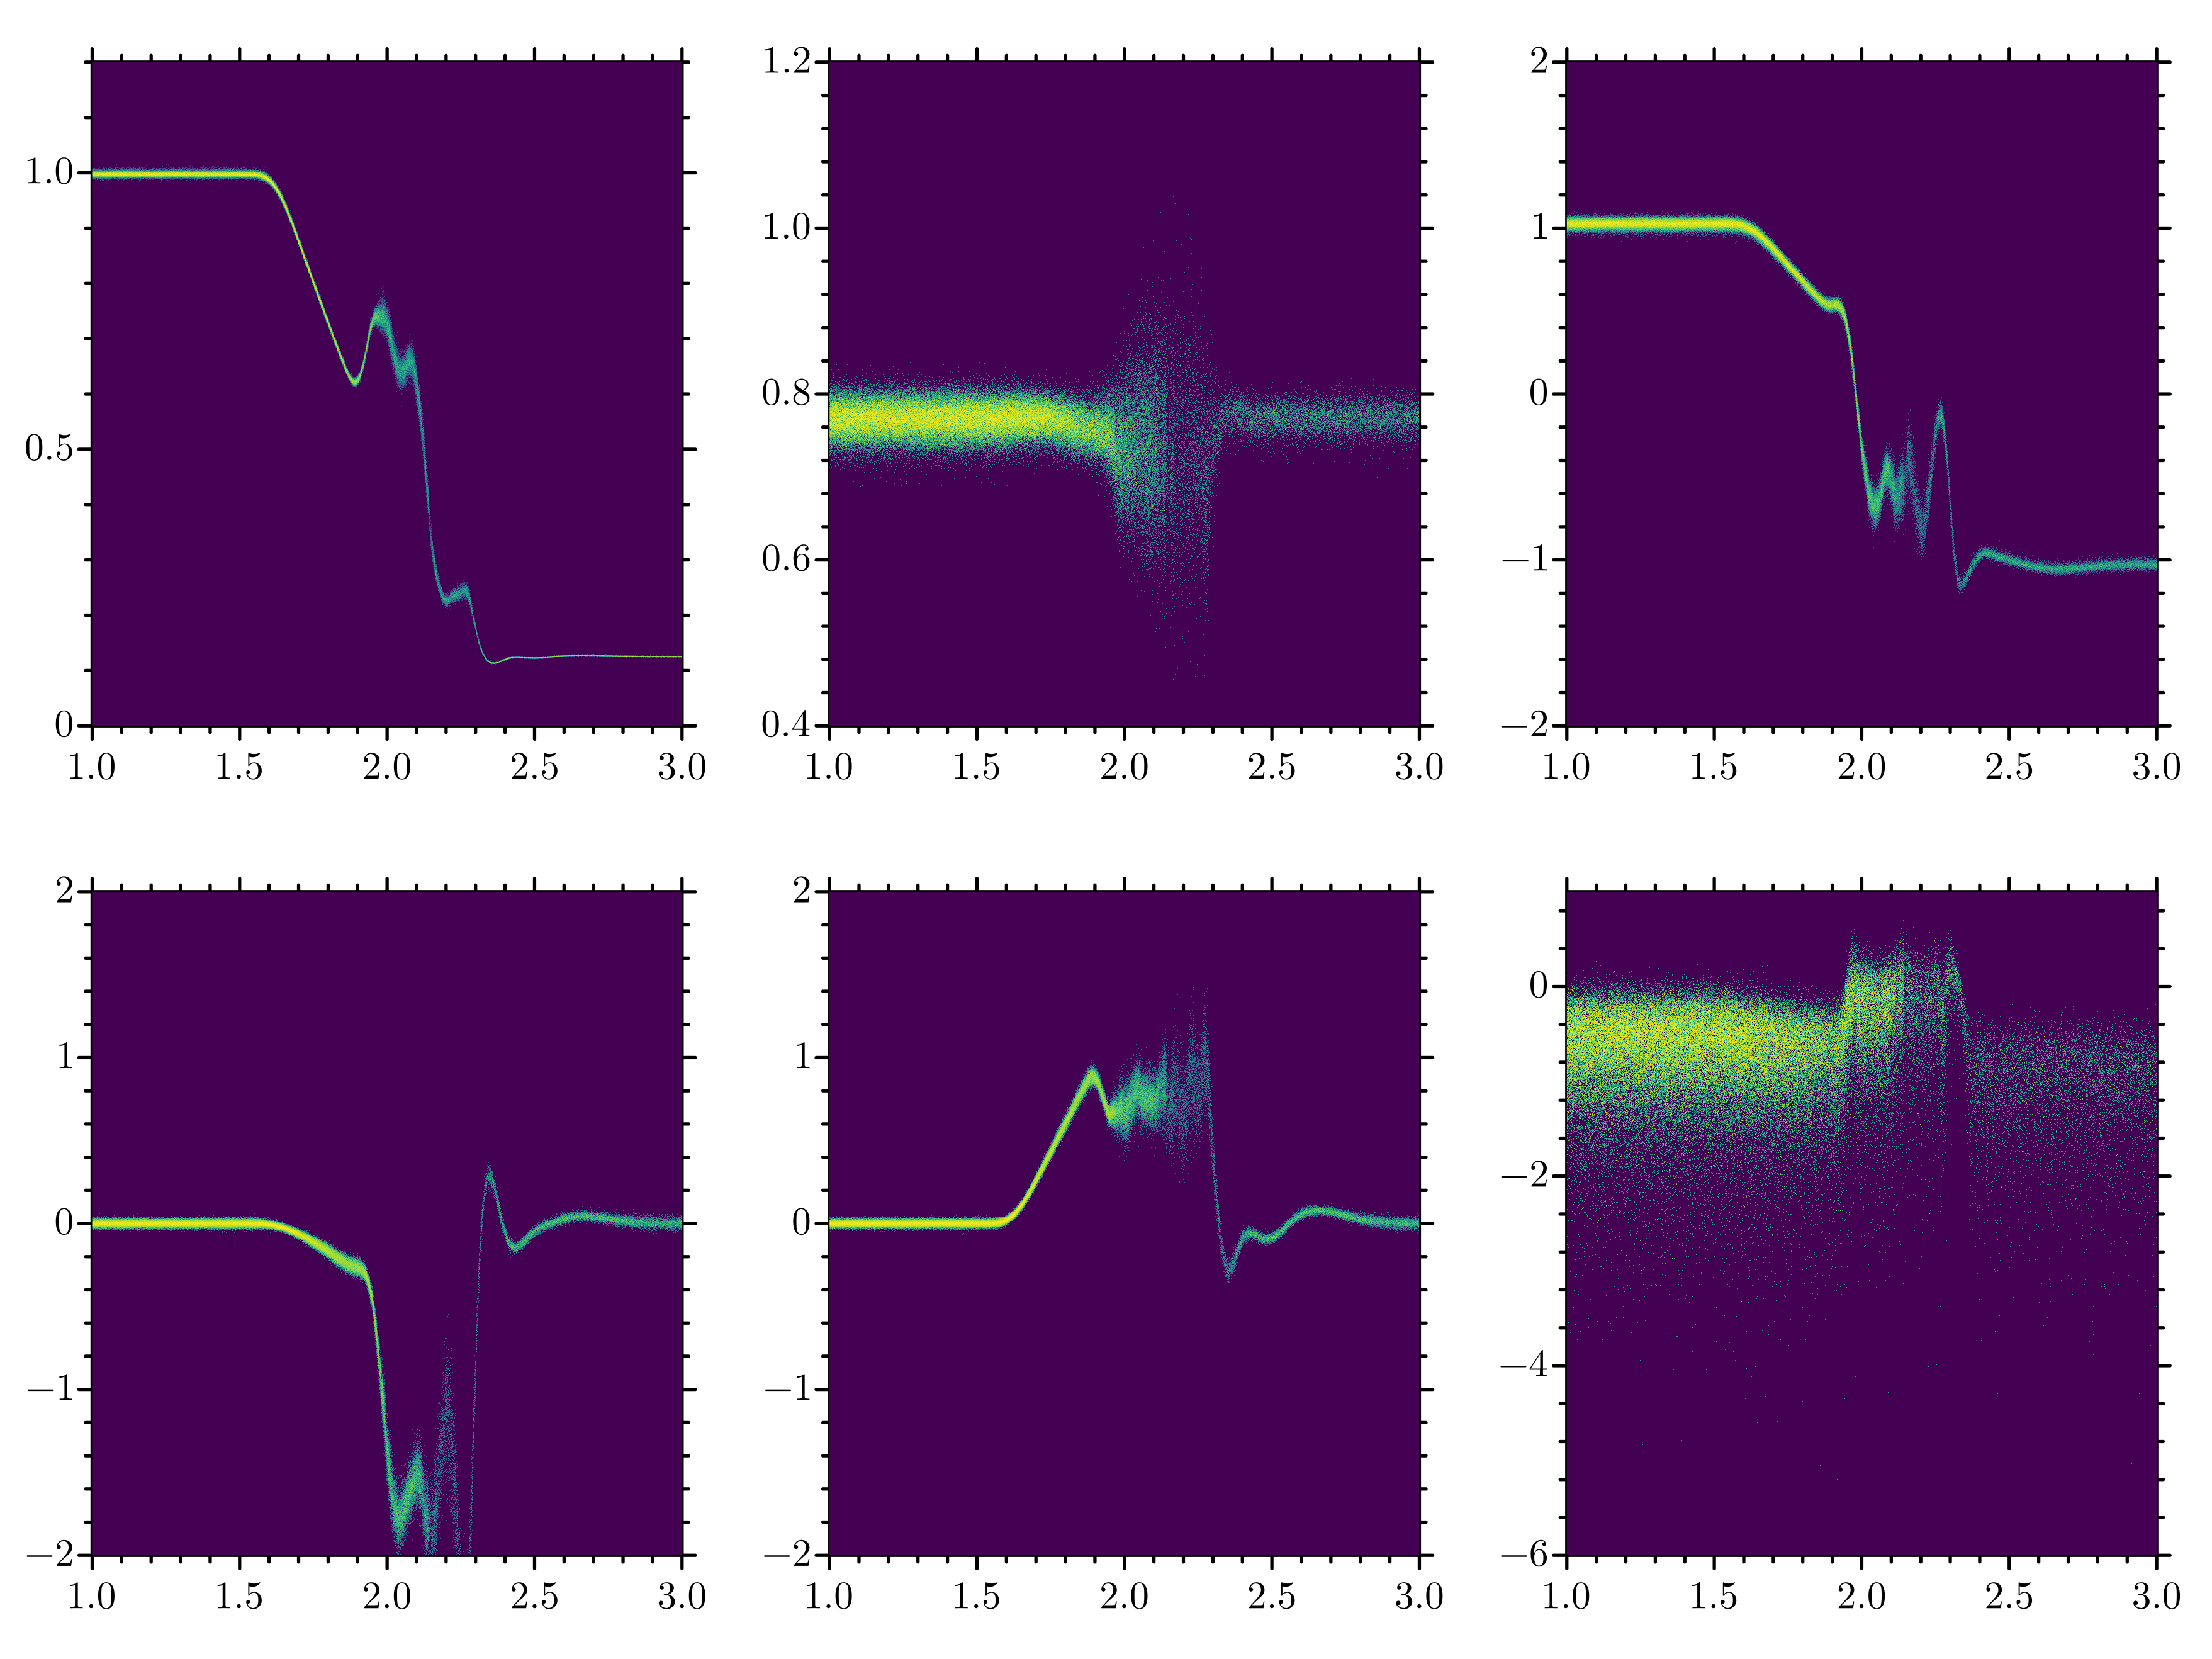

In [94]:
subplot(2, 3, 1)
shade(x,rho,xlim=(1,3),ylim=(0,1.2))
subplot(2, 3, 2)
shade(x,Bx,xlim=(1.0,3))
subplot(2, 3, 3)
shade(x,By,xlim=(1,3), ylim=(-2,2))
subplot(2, 3, 4)
shade(x,Vy,xlim=(1,3), ylim=(-2,2))
subplot(2, 3, 5)
shade(x,Vx,xlim=(1,3), ylim=(-2,2))
subplot(2, 3, 6)
shade(x,log10.(abs.(divB)),xlim=(1,3))

In [309]:
function read_snap(filename :: String)
    
    pos  = h5read(filename,"PartType0/Coordinates")
    Bfl  = h5read(filename,"PartType0/Bfield") 
    Vel  = h5read(filename,"PartType0/Velocities")
    alp  = h5read(filename,"PartType0/EPalpha")
    bet  = h5read(filename,"PartType0/EPbeta")
    divB = h5read(filename,"PartType0/divB")
    #Ids  = h5read(filename,"PartType0/ParticleIDs")
    h    = h5read(filename,"PartType0/SmoothingLengths")
    rho  = h5read(filename,"PartType0/Densities")
    head = h5readattr(filename,"Header")

    print("Leyendo ",filename," at time: ",head["Time"],"\n")
    x = pos[1,:]
    y = pos[2,:]
    z = pos[3,:]
    bx = Bfl[1,:]
    by = Bfl[2,:]
    bz = Bfl[3,:]
    Vx = Vel[1,:]
    Vy = Vel[2,:]
    Vz = Vel[3,:]
    
    v2 = Vx.*Vx.+Vy.*Vy.+Vz.*Vz
    b2 = by.*by.+by.*by.+bz.*bz
    
    Npart=size(b2,1)
        
    print("Min x:",minimum(x)," / Max x:",maximum(x),"\n")
    print("Min y:",minimum(y)," / Max y:",maximum(y),"\n")
    print("Min z:",minimum(z)," / Max z:",maximum(z),"\n")
    print("Min h:",minimum(h)," / Max h:",maximum(h),"\n")
    (Dict(:H => head, :x=>pos, :bfl=> Bfl, :b2=>b2, :v=>Vel, :v2=>v2, 
            :divB=>divB, :rho=>rho, :hsml=>h,:bet=> bet, :alp=> alp, Npart=> Npart))
end

function do_heat(data,what,Nmax)
    #Nmax=128
    #x=x.-minimum(x)
    #y=y.-minimum(y)
    #b2=data[what]
    b2=what
    Npart=size(b2,1)
    Lbox=1.0#+maximum(x)
    A = ones((Nmax, Nmax))*minimum(b2)
    grid = ones((Nmax, Nmax))
    #grid = [Set{Int}() for x=1:Nmax, y=1:Nmax];
    #insert(grid) = p -> push!(grid[trunc(Int, p.x/Lbox*Nmax), trunc(Int, p.y/Lbox*Nmax)], p.n);
    #foreach(insert(grid), data)
    x=data[:x][1,:]
    y=data[:x][2,:]
    for ind = 1:Npart
        i,j = trunc(Int, x[ind]/Lbox*Nmax+1), trunc(Int, y[ind]/Lbox*Nmax+1)
        A[i,j] += b2[ind]
        grid[i,j] += 1 
    end
    AA=log10.(A./grid)
    #AA=(A./grid)
    (AA)
end

function do_table(data,Nmax)
    #### Data
    x=data[:x][1,:]
    xmin=minimum(x)
    xmax=maximum(x)
    zone=(round(xmax)-round(xmin))/2.
    print(zone)
    x = x .- zone # move to 0
    x = 2.0 .* x ./ zone #normalize -1 to 1 just one side of the tube
    
    rho=data[:rho]
    divB=data[:divB]
    Bx=data[:bfl][1,:]
    By=data[:bfl][2,:]
    Bz=data[:bfl][3,:]
    
    Vx=data[:v][1,:]
    Vy=data[:v][2,:]
    Vz=data[:v][3,:]
    
    divB=data[:hsml] .* data[:divB]./sqrt.(data[:b2])
    
    
    delta=(2.0)/Nmax
    #### Out data
    xx=range(-1.0,1.0,Nmax) # xx[1]>> min  xx[Nmax]>> max
    rrho =ones(Nmax-1,2)
    ddivB=ones(Nmax-1,2)
    BBx=ones(Nmax-1,2)
    BBy=ones(Nmax-1,2)
    BBz=ones(Nmax-1,2)
    VVx=ones(Nmax-1,2)
    VVy=ones(Nmax-1,2)
    VVz=ones(Nmax-1,2)
    
    for ind=1:Nmax-1
        idx=(x .>= xx[ind] .&& x .< xx[ind+1])
        rrho[ind,1] , rrho[ind,2]  = mean(rho[idx])  , std(rho[idx])
        ddivB[ind,1], ddivB[ind,2] = mean(divB[idx]) , std(divB[idx])
        BBx[ind,1]  , BBx[ind,2]   = mean(Bx[idx])   , std(Bx[idx])
        BBy[ind,1]  , BBy[ind,2]   = mean(By[idx])   , std(By[idx])
        BBz[ind,1]  , BBz[ind,2]   = mean(Bz[idx])   , std(Bz[idx])
        
        VVx[ind,1]  , VVx[ind,2]   = mean(Vx[idx])   , std(Vx[idx])
        VVy[ind,1]  , VVy[ind,2]   = mean(Vy[idx])   , std(Vy[idx])
        VVz[ind,1]  , VVz[ind,2]   = mean(Vz[idx])   , std(Vz[idx])
    end
    
    xx=range(-1.0+delta,1.0-delta,Nmax-1) # xx[1]>> mean   xx[Nmax]>> mean
    
    (Dict(:x => xx, :rho=>rrho, :divB=>ddivB,
            :Bx=>BBx, :By=>BBy , :Bz=> BBz,
            :Vx=>VVx, :Vy=>VVy , :Vz=> VVz  ))
end



function exact_BW(time)
     tfac = time/0.1
     xmin = -1.0
     xmax = 1.0
     #### def vars
     #vz     = 0.
     #Bz     = 0.
     #Bxzero = 0.75
     npts   = 14
     MU0_1  = 1.0/sqrt(4.0*pi)
     #### 
     xpts = zeros(npts)
     rho  = zeros(npts)
     pr   = zeros(npts)
     vx   = zeros(npts)
     vy   = zeros(npts)
     vz   = zeros(npts)
     bx   = ones(npts).*0.75
     bz   = zeros(npts)
     by   = zeros(npts)
     ####
    
     xpts[1]      = xmin
     xpts[2]      = -0.18*tfac
     xpts[3]      = -0.08*tfac
     xpts[4:6]   .= -0.03*tfac
     xpts[7]      = -0.005*tfac
     xpts[8:9]   .= 0.06*tfac
     xpts[10:11] .= 0.147*tfac
     xpts[12]     = 0.33*tfac
     xpts[13]     = 0.36*tfac
     xpts[14]     = xmax

     rho[1:2]   .= 1.0
     rho[3:4]   .= 0.67623
     rho[5]      = 0.827
     rho[6]      = 0.775
     rho[7:8]   .= 0.6962
     rho[9:10]  .= 0.2352
     rho[11:12] .= 0.117
     rho[13:14] .= 0.125

     pr[1:2]    .= 1.0
     pr[3:4]    .= 0.447
     pr[5]       = 0.727219
     pr[6]       = 0.6
     pr[7:10]   .= 0.5160
     pr[11:12]  .= 0.0876
     pr[13:14]  .= 0.1
 
     vx[1:2]    .= 0.0
     vx[3:4]    .= 0.63721
     vx[5]       = 0.48
     vx[6]       = 0.52
     vx[7:10]   .= 0.600
     vx[11:12]  .= -0.24
     vx[13:14]  .= 0.0
 
     vy[1:2]    .= 0.0
     vy[3:4]    .= -0.23345
     vy[5]       = -1.3
     vy[6]       = -1.4
     vy[7:10]   .= -1.584
     vy[11:12]  .= -0.166
     vy[13:14]  .= 0.
 
     by[1:2]   .= 1.0
     by[3:4]   .= 2.1*MU0_1
     by[5]      = -1.2*MU0_1
     by[6]      = -1.3*MU0_1
     by[7:10]  .= -1.9*MU0_1
     by[11:12] .= -3.25*MU0_1
     by[13:14] .= -1.0
    
     (Dict(:xpts=>xpts, :rho=>rho, :pr=>pr,
            :vx=> vx, :vy=>vy, :vz=>vz,
            :bx=> bx, :by=>by, :bz=>bz))
end

function do_6plot(gsnap)
    a=do_table(gsnap,256)
    ex=exact_BW(0.2)
    GRUtils.hold(false)
    subplot(1,1,1)
########## plot1
    subplot(2,3,1)
    plot(a[:x],a[:rho][:,1],ylim=(0,1.1),xlabel="X",ylabel="Rho")
    GRUtils.hold(true)
    errorbar(a[:x],a[:rho][:,1],a[:rho][:,2])
    oplot(ex[:xpts],ex[:rho],"-r")
######## plot2
    subplot(2,3,2)
    plot(a[:x],a[:Bx][:,1],ylim=(-1.1,1.1),xlabel="X",ylabel="Bx/By")
    GRUtils.hold(true)
    errorbar(a[:x],a[:Bx][:,1],a[:Bx][:,2])
    oplot(ex[:xpts],ex[:bx],"-r")
    plot(a[:x],a[:By][:,1])#,xlabel="X",ylabel="By")
    errorbar(a[:x],a[:By][:,1],a[:By][:,2])
    oplot(ex[:xpts],ex[:by],"-g")
####### plot3
    subplot(2,3,3)
    plot(a[:x],a[:Vx][:,1],ylim=(-0.4,1.0),xlabel="X",ylabel="Vx/Vz")
    GRUtils.hold(true)
    errorbar(a[:x],a[:Vx][:,1],a[:Vx][:,2])
    oplot(ex[:xpts],ex[:vx],"-r")
    plot(a[:x],a[:Vz][:,1])
    errorbar(a[:x],a[:Vz][:,1],a[:Vz][:,2])
    oplot(ex[:xpts],ex[:vz],"-g")
###### plot 4
    subplot(2,3,4)
    plot(a[:x],a[:Vy][:,1],xlabel="X",ylabel="Vy")
    GRUtils.hold(true)
    errorbar(a[:x],a[:Vy][:,1],a[:Vy][:,2])
    oplot(ex[:xpts],ex[:vy],"-r")
###### plot 5
    subplot(2,3,5)
    plot(a[:x],log10.(abs.(a[:divB][:,1])),xlabel="X",ylabel="Err|divB|")
    #GRUtils.hold(true)
    #errorbar(a[:x],abs.(a[:divB][:,1]),a[:divB][:,2])
end

do_6plot (generic function with 1 method)

Leyendo BrioWu_0020.hdf5 at time: [0.4]
Min x:3.439952808850853e-6 / Max x:7.999996941873068
Min y:9.768040114543246e-8 / Max y:0.9999972728257819
Min z:2.463366795435462e-6 / Max z:0.9999991820297697
Min h:0.019223604 / Max h:0.03996833
4.0

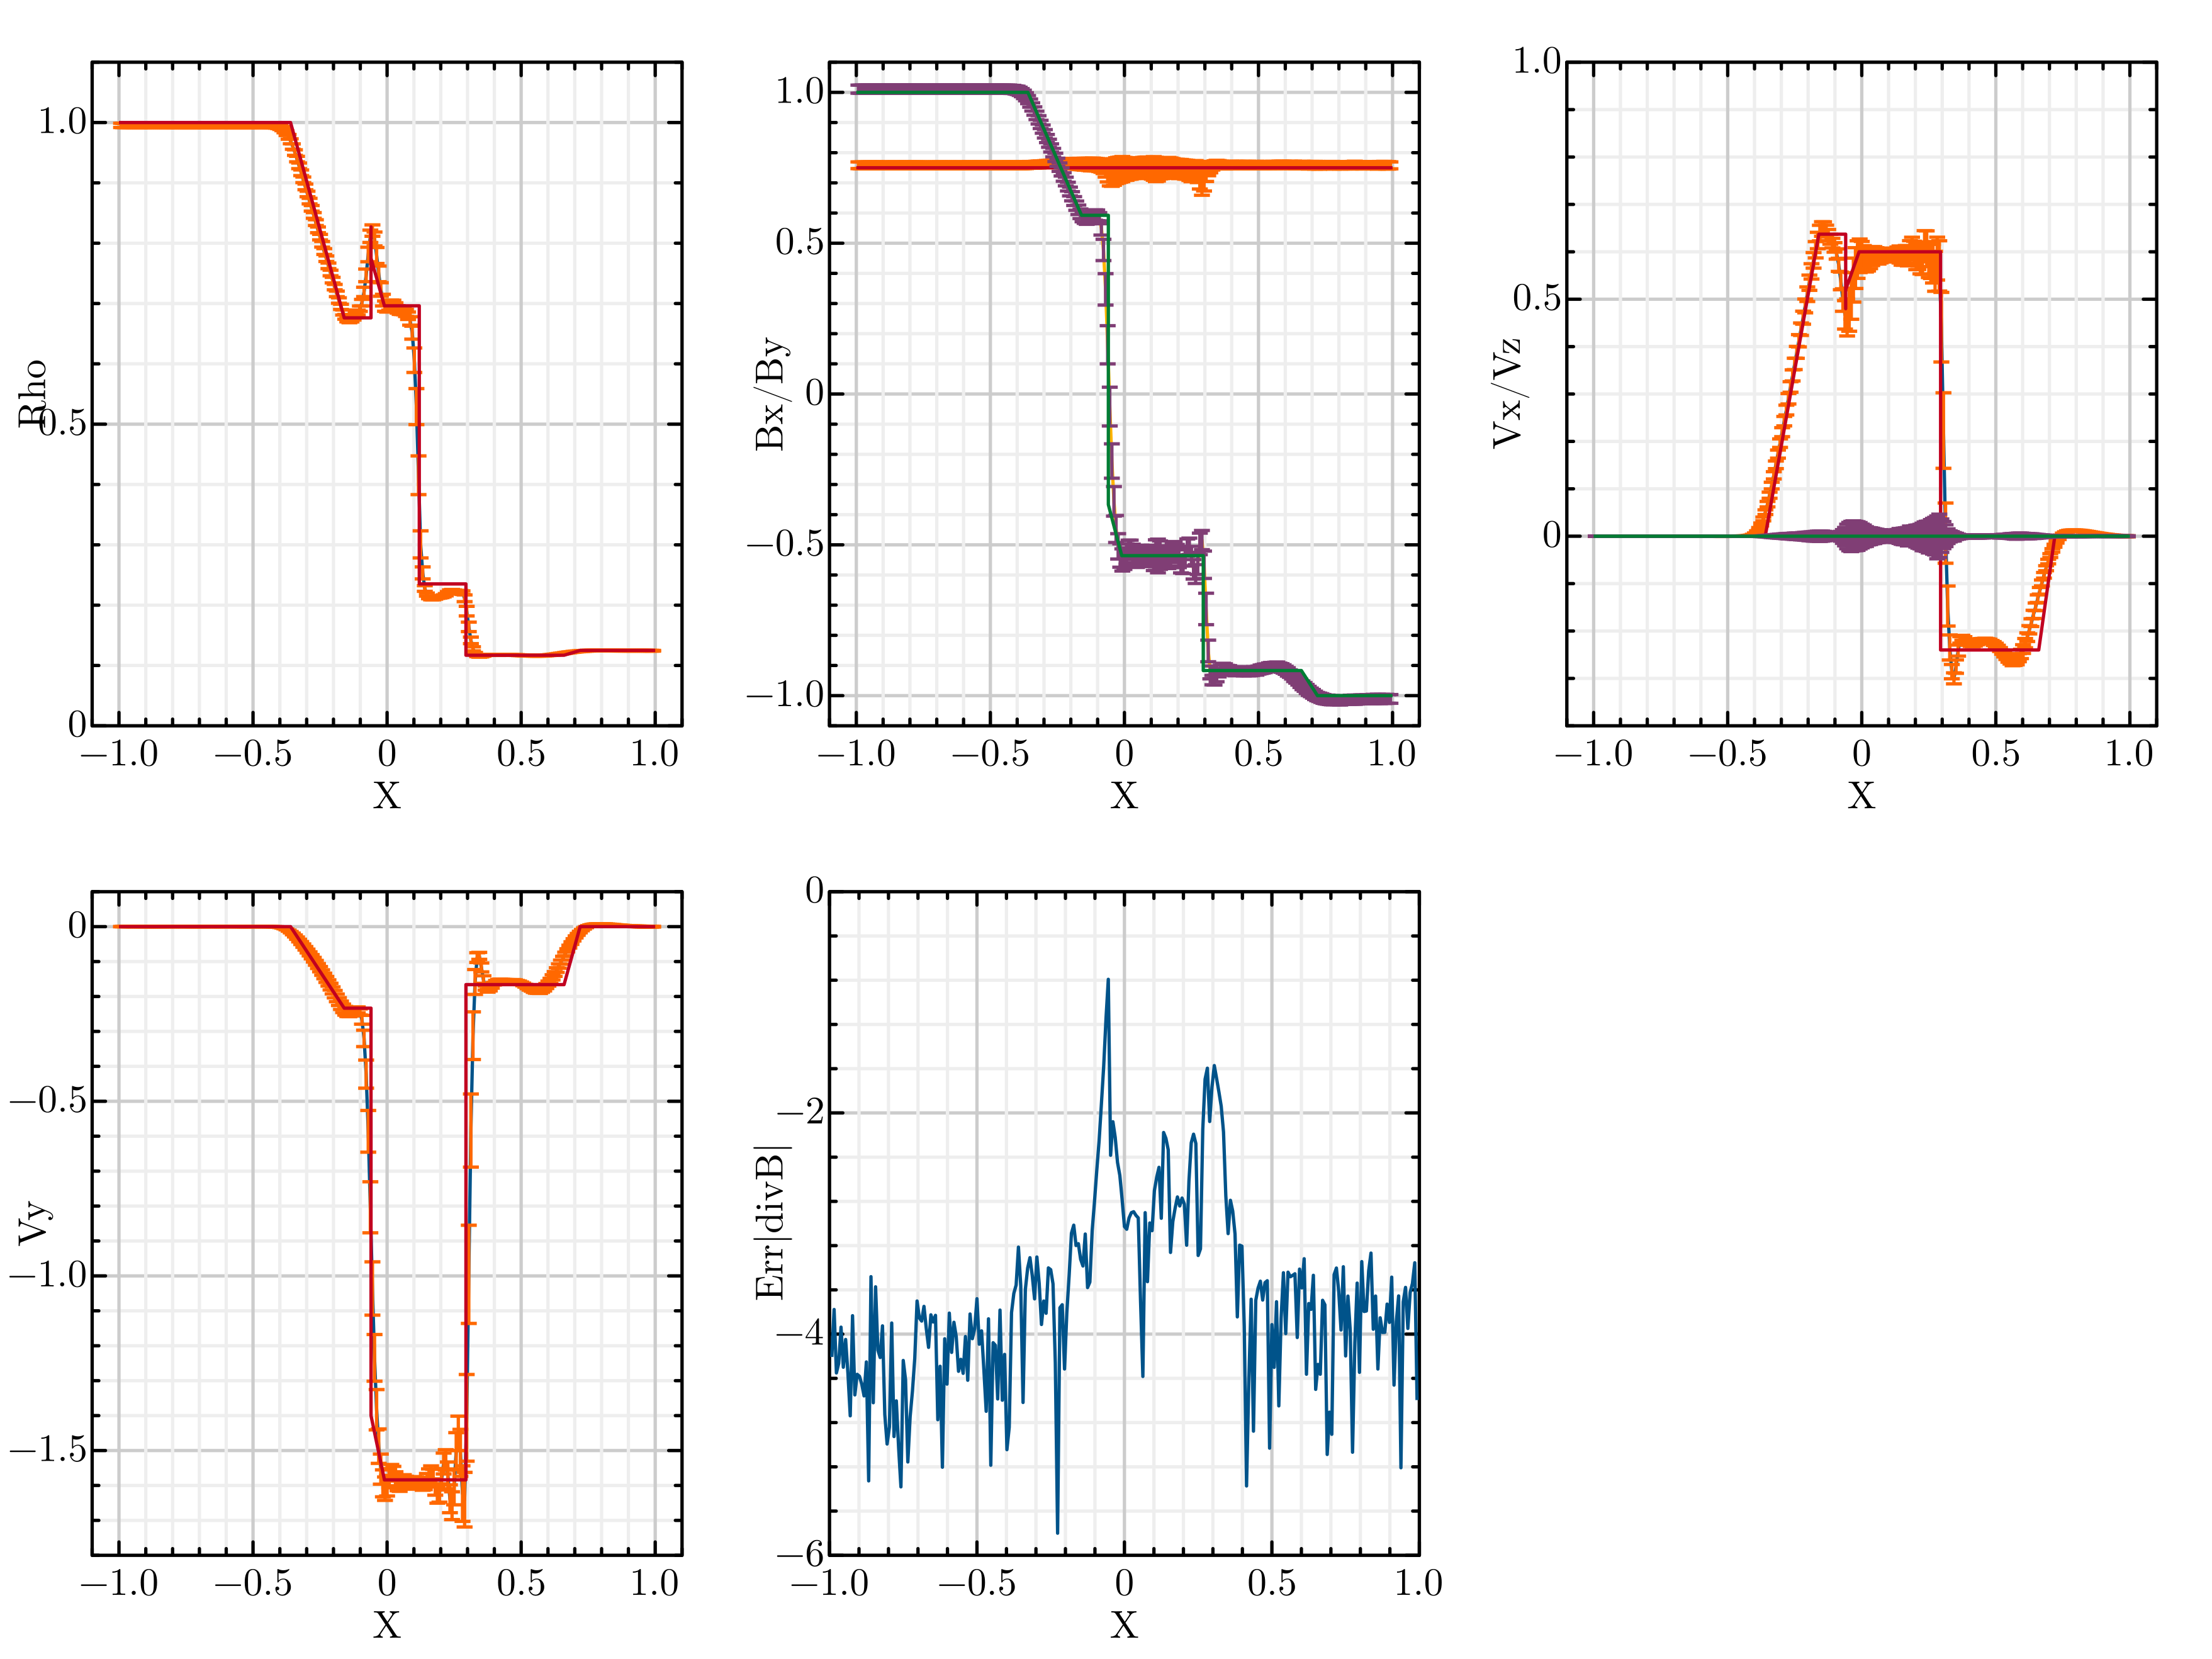

In [313]:
gsnap=read_snap("BrioWu_0020.hdf5")
do_6plot(gsnap)
#savefig("Test5a_minimal.x4.pdf")

Leyendo BrioWu_anda.hdf5 at time: [0.2]
Min x:1.092803871072849e-6 / Max x:3.999995300346906
Min y:1.49163498197602e-6 / Max y:0.9999995187150353
Min z:1.0322337316015506e-6 / Max z:0.9999994393170231
Min h:0.01922285 / Max h:0.04035066


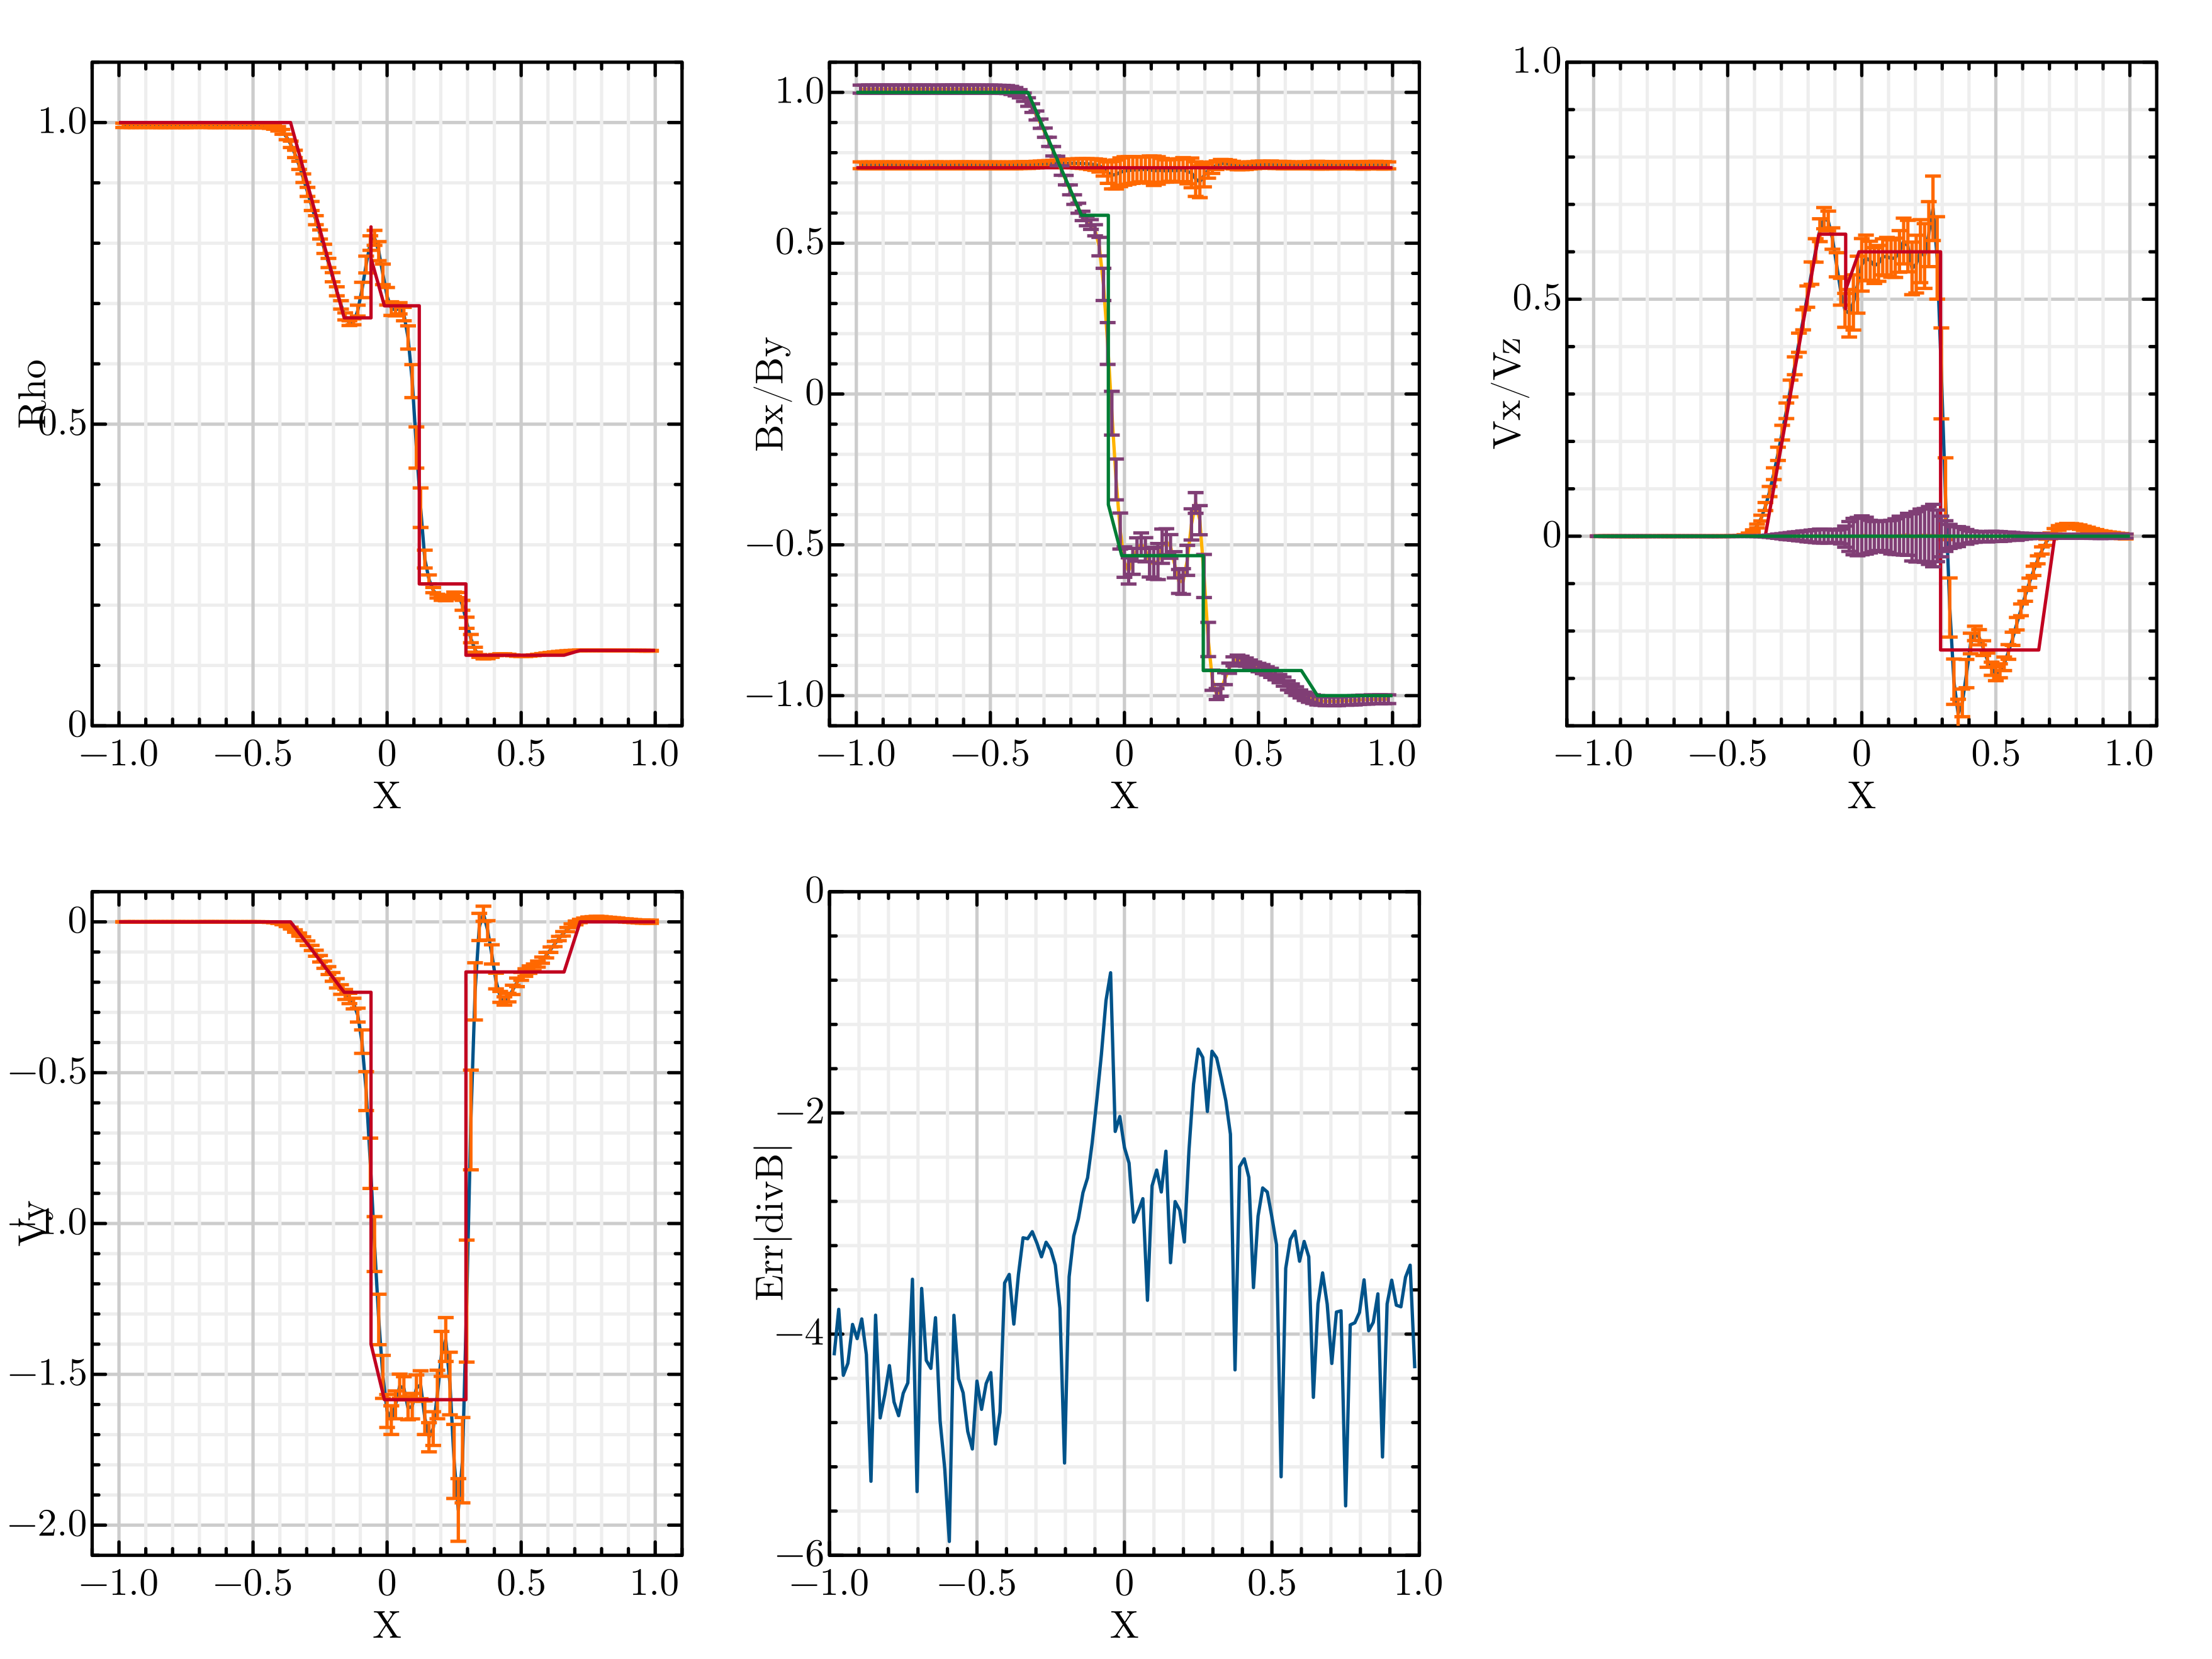

In [267]:
gsnap=read_snap("BrioWu_anda.hdf5")
do_6plot(gsnap)

In [287]:
gsnap=read_snap("BrioWu_0002.hdf5")
x=gsnap[:x][1,:]
rho=gsnap[:rho]
Bx=gsnap[:bfl][1,:]
By=gsnap[:bfl][2,:]
Bz=gsnap[:bfl][3,:]
divB=gsnap[:divB]
Vx=gsnap[:v][1,:]
Vy=gsnap[:v][2,:]
Vz=gsnap[:v][3,:]

Leyendo BrioWu_0002.hdf5 at time: [0.04000000000000001]
Min x:1.2984890729156533e-6 / Max x:5.999999929205976
Min y:3.3755239191890406e-6 / Max y:0.9999999647046263
Min z:1.5876506497214888e-6 / Max z:0.9999989202861055
Min h:0.009555946 / Max h:0.05033414


1179648-element Vector{Float32}:
 -0.021735877
 -0.09286796
 -0.16610394
 -0.530883
  0.0703822
  0.12434587
  0.075888015
 -0.29971442
  0.29570457
  0.17628975
 -0.018107418
  0.24034241
  0.28306744
  ⋮
  0.00043361392
 -0.028275205
  0.029050656
 -0.030918645
 -0.018142177
  0.30518737
  0.031200303
  0.013860637
 -0.05167721
  0.043720376
  0.027730405
  0.094583765

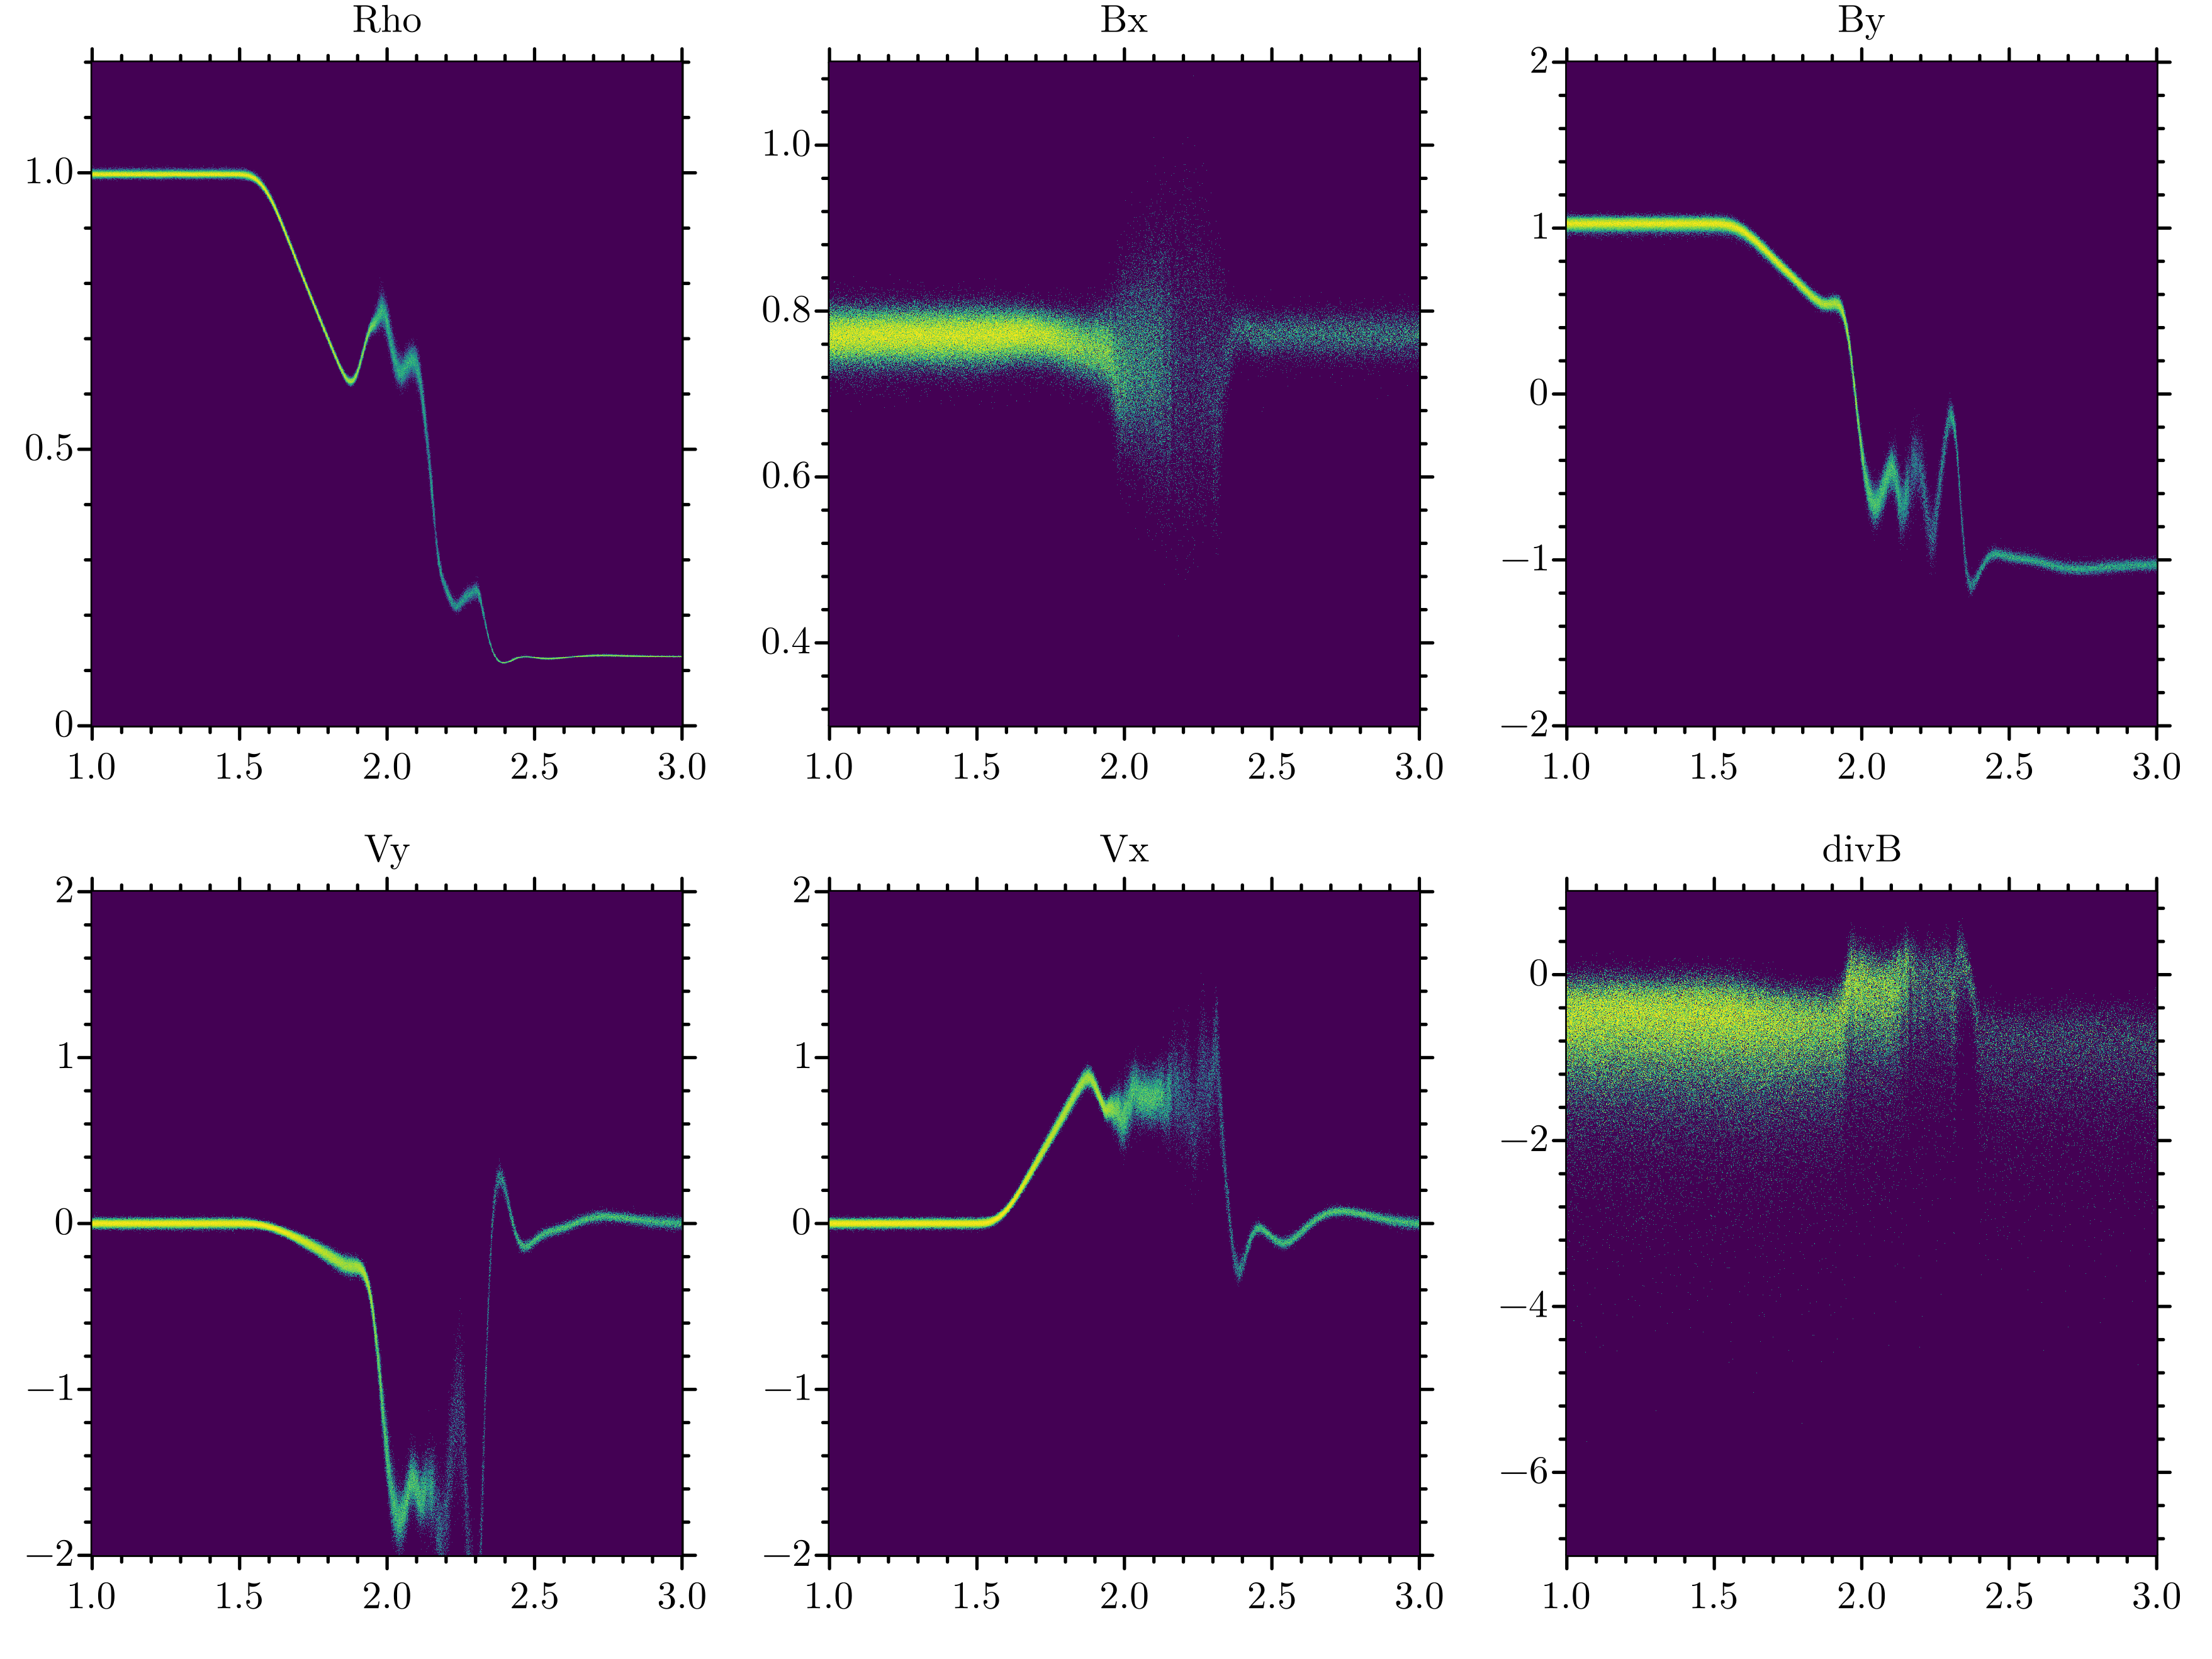

In [156]:

subplot(2, 3, 1)
shade(x,rho,xlim=(1,3),ylim=(0,1.2),title="Rho")
subplot(2, 3, 2)
shade(x,Bx,xlim=(1.0,3),title="Bx")
subplot(2, 3, 3)
shade(x,By,xlim=(1,3), ylim=(-2,2),title="By")
subplot(2, 3, 4)
shade(x,Vy,xlim=(1,3), ylim=(-2,2),title="Vy")
subplot(2, 3, 5)
shade(x,Vx,xlim=(1,3), ylim=(-2,2),title="Vx")
subplot(2, 3, 6)
shade(x,log10.(abs.(divB)),xlim=(1,3),title="divB")

In [226]:
a=exact_BW(0.2)

Dict{Any, Vector{Float64}} with 8 entries:
  [0.0, 0.0, 0.0, 0.0, 0.0… => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.…
  :bx                       => [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,…
  :xpts                     => [-1.0, -0.36, -0.16, -0.06, -0.06, -0.06, -0.01,…
  :rho                      => [1.0, 1.0, 0.67623, 0.67623, 0.827, 0.775, 0.696…
  :vy                       => [0.0, 0.0, -0.23345, -0.23345, -1.3, -1.4, -1.58…
  :by                       => [1.0, 1.0, 0.592399, 0.592399, -0.338514, -0.366…
  :pr                       => [1.0, 1.0, 0.447, 0.447, 0.727219, 0.6, 0.516, 0…
  :vx                       => [0.0, 0.0, 0.63721, 0.63721, 0.48, 0.52, 0.6, 0.…

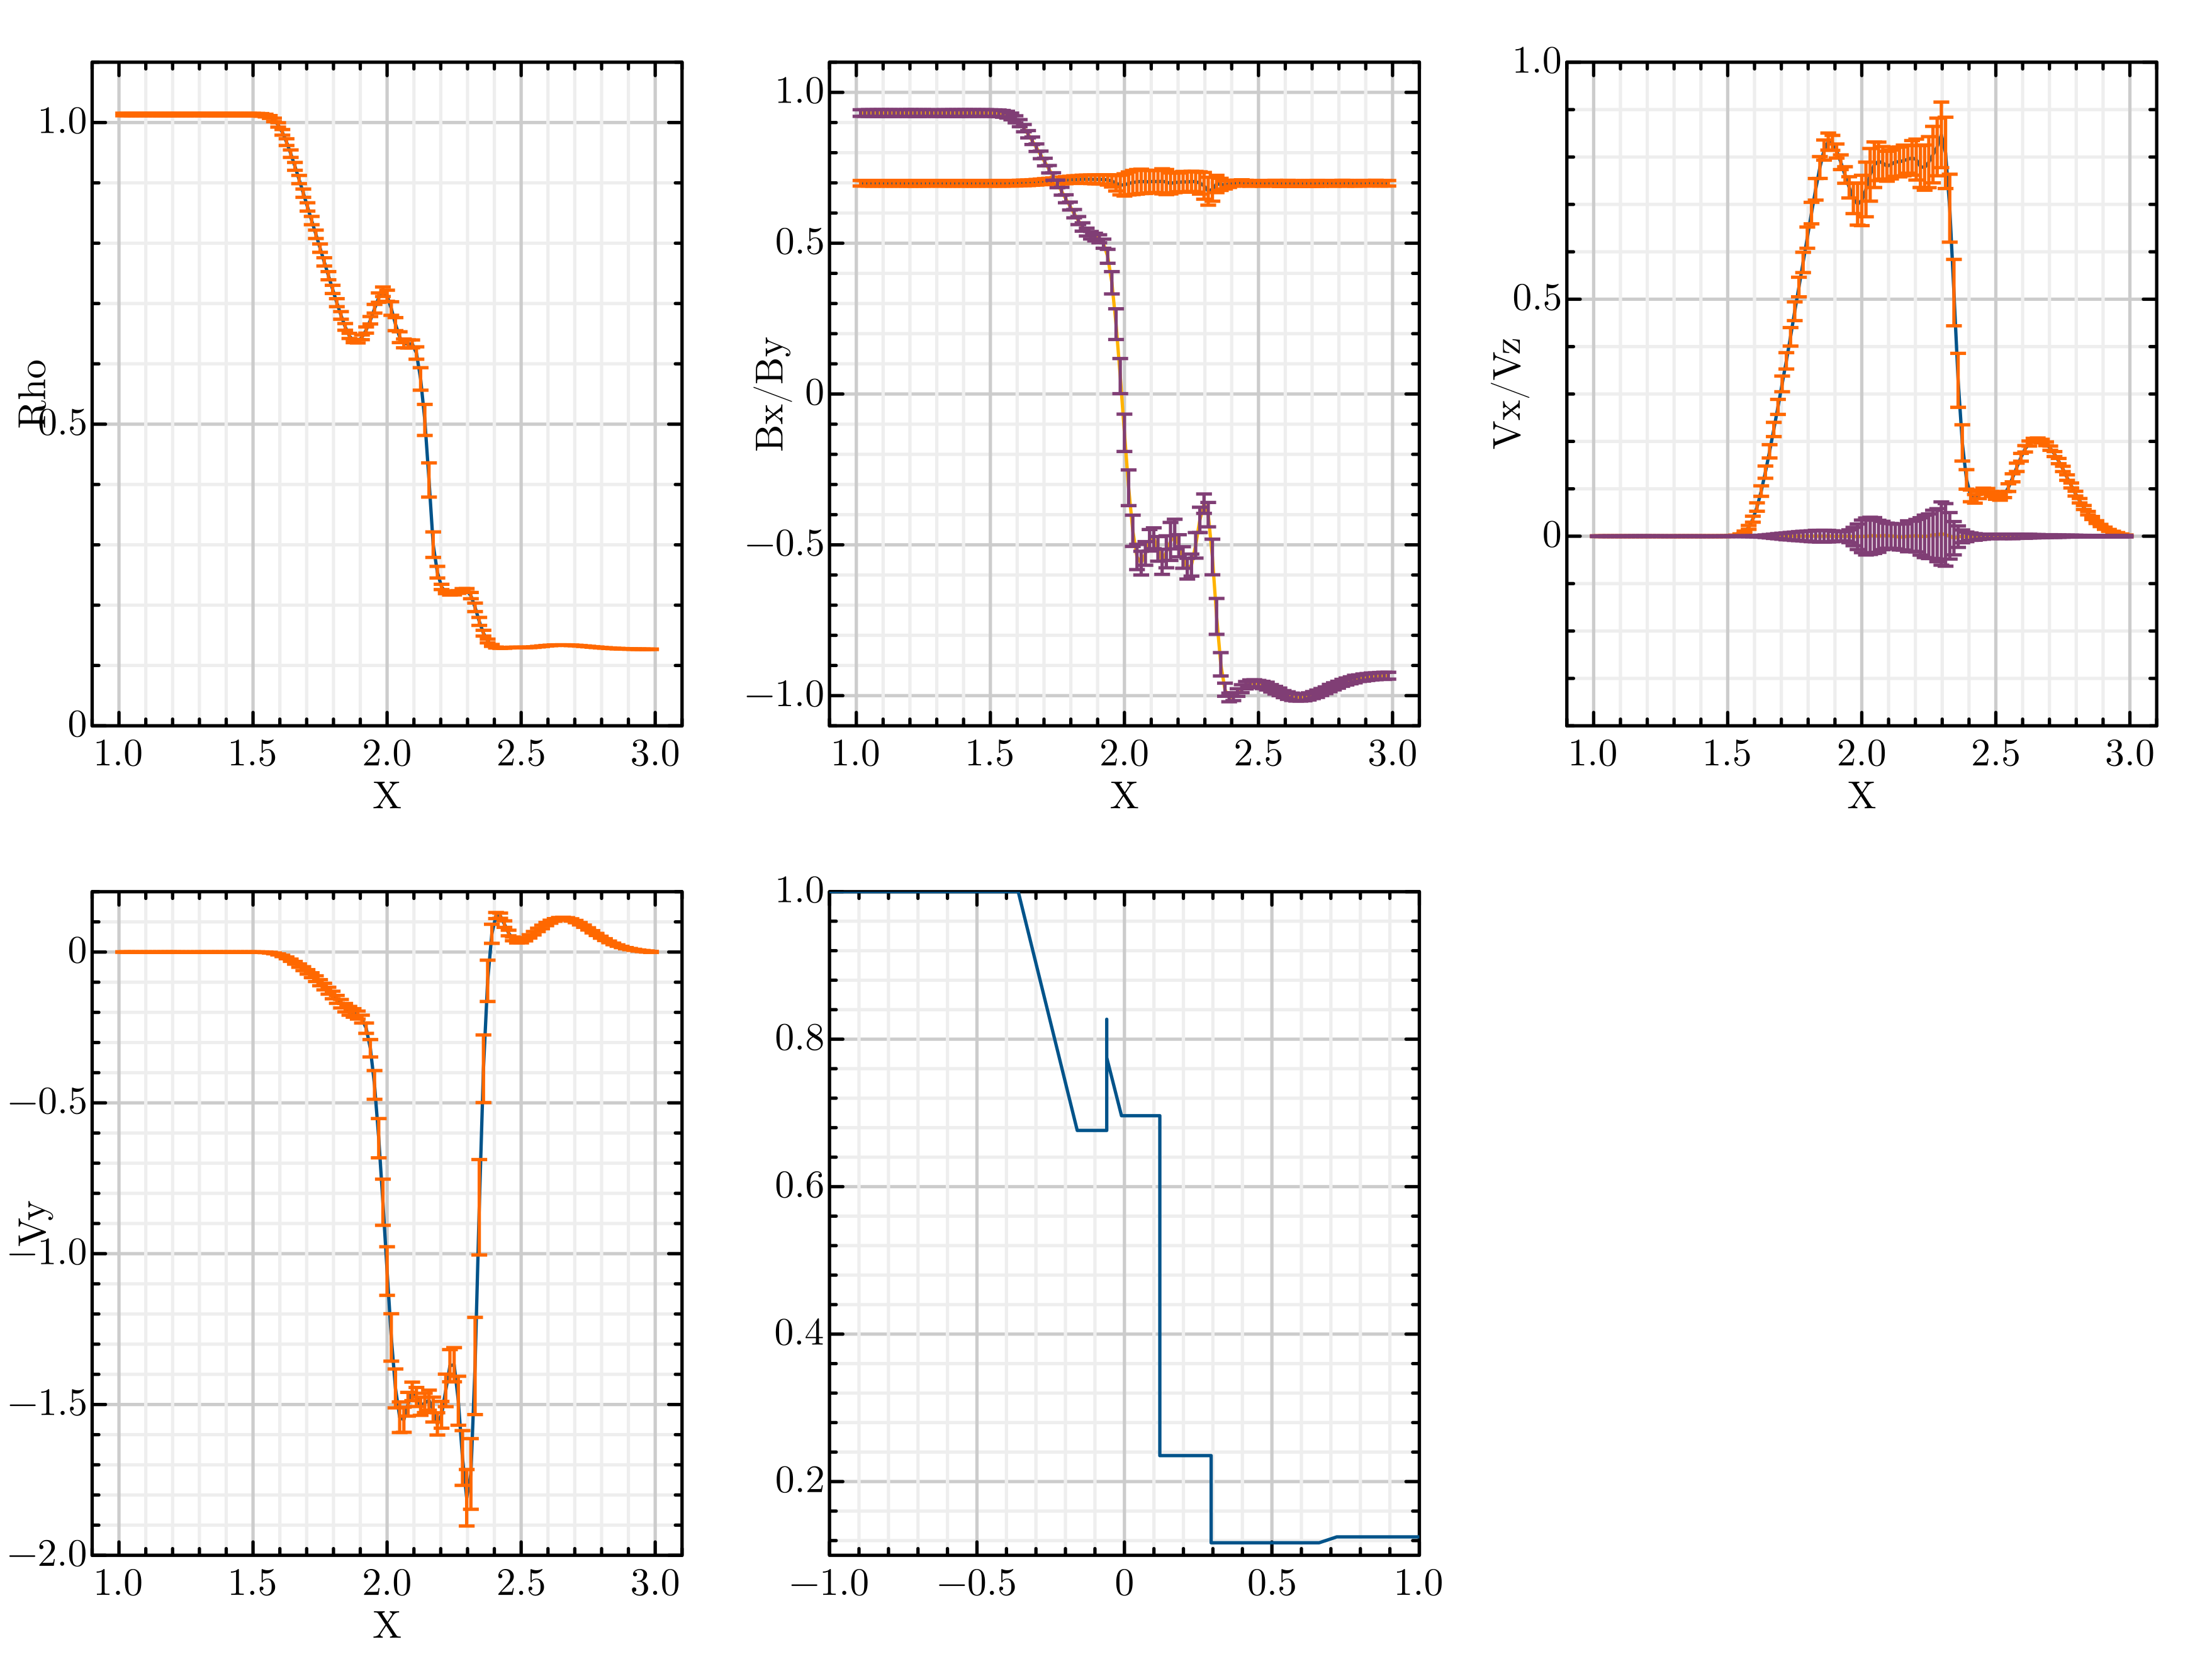

In [227]:
plot(a[:xpts],a[:rho])